In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import math
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [4]:
os.chdir(r'D:\New folder')
df = pd.read_csv('experiment.csv')

df.count()

filename    625
text        625
age         625
gender      625
accent      625
dtype: int64

### 1 = male, 0 = female

In [1]:
def no_segment_save_mfcc(dataset, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    sample_rate = 22050
    num_segments=5
    n_samples = len(df)
    data = {"MFCC" : [], "label": []}
    amount = 0
    
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(dataset['filename'], dataset['gender'])), "Loading data", total=n_samples):
        signal, sr = librosa.core.load("cv-valid-train/"+filename, sr=sample_rate, duration=3)
        duration = librosa.get_duration(signal)
        if duration < 3:
            continue
        else:
            amount = amount +1
            #duration = 1
            #samples_per_track = sample_rate * duration

            #samples_per_segment = int(samples_per_track / num_segments) #samples_per_segment = int(samples_per_track / duration)

            #num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / 512) #samples_per_segment / hop_length
            #print(num_mfcc_vectors_per_segment)
            #librosa.feature.mfcc(y=None, sr=22050, S=None, n_mfcc=20, **kwargs)

            #start = samples_per_segment * d
            #finish = start + samples_per_segment
            #mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            MFCC = librosa.feature.mfcc(signal, n_fft=2048, hop_length=512, n_mfcc=13)
            MFCC = MFCC.T

            
            data["MFCC"].append(MFCC.tolist())
            data["label"].append(gender)

    
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(amount)

In [2]:
def save_mfcc(dataset, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    sample_rate = 22050
    num_segments=5
    n_samples = len(df)
    data = {"MFCC" : [], "label": []}
    
    
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(dataset['filename'], dataset['gender'])), "Loading data", total=n_samples):
        signal, sr = librosa.core.load("cv-valid-train/"+filename, sr=sample_rate, duration=3)
        duration = librosa.get_duration(signal)
        #duration = 1
        samples_per_track = sample_rate * duration

        samples_per_segment = int(samples_per_track / num_segments) #samples_per_segment = int(samples_per_track / duration)

        num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / 512) #samples_per_segment / hop_length
        #print(num_mfcc_vectors_per_segment)
        #librosa.feature.mfcc(y=None, sr=22050, S=None, n_mfcc=20, **kwargs)

        for d in range(num_segments):
            start = samples_per_segment * d
            finish = start + samples_per_segment
            #mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            MFCC = librosa.feature.mfcc(signal[start:finish], n_fft=2048, hop_length=512, n_mfcc=13)
            MFCC = MFCC.T

            if len(MFCC) == num_mfcc_vectors_per_segment:
                data["MFCC"].append(MFCC.tolist())
                data["label"].append(gender)

    
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [49]:
no_segment_save_mfcc(df, "no_segment_gender_experiment.json")

Loading data: 100%|██████████| 625/625 [01:41<00:00,  6.13it/s]


625


In [ ]:
#save_mfcc(df, "data_gender.json")

Loading data:   2%|▏         | 674/32838 [01:10<1:05:51,  8.14it/s]C:\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loading data:   8%|▊         | 2701/32838 [04:46<55:01,  9.13it/s]  

In [6]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCC"])
    y = np.array(data["label"])
    #print(X.shape[0]))
        
    return X, y
#load_data('data_11.json')

In [7]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.tight_layout()
    plt.savefig('gender-classification.png')
    plt.show()

In [8]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)
    #X=np.asarray(X).astype(np.float32, dtype=object)
    #y=np.asarray(y).astype(np.float32, dtype=object)
    


    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    
    
    
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test
#print(X_train.shape)

In [9]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (1, 1), activation='relu'))
    model.add(keras.layers.MaxPooling2D((1, 1), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
        # 4th conv layer
    #model.add(keras.layers.Conv2D(128, (1, 1), activation='relu'))
    #model.add(keras.layers.MaxPooling2D((1, 1), strides=(2, 2), padding='same'))
    #model.add(keras.layers.BatchNormalization())
    

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [10]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    #print("Target: {}, Predicted label: {}".format(y, predicted_index))
    return predicted_index

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 2, 128)        4

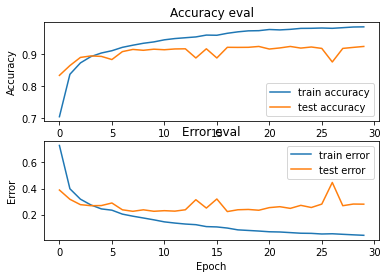

71/71 - 1s - loss: 0.2705 - accuracy: 0.9238

Test accuracy: 0.9238221049308777


array([1], dtype=int64)

In [11]:
DATA_PATH = ('no_segment_gender_train.json')

# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.1, 0.2)

# create network
#input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

In [54]:
model.save("model/gender")

INFO:tensorflow:Assets written to: model/assets


In [65]:
def prepare_experiment(data):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
    
    
    df1 = pd.DataFrame(columns = ['filename', 'M_gender']) 
    df2 = pd.read_csv("experiment.csv")
    
    # load data
    X, y = load_data(data)
    
    #add an extra layer
    X = X[..., np.newaxis]
    
    
    correct = 0
    # test predictions
    for i in tqdm.tqdm(range(len(X)), desc ="testing", total=len(X)): 
        target = "[" + str(y[i]) + "]"
        prediction = str(predict(model,X[i],y[i]))
        new_row = {'filename': df2['filename'][i],  'M_gender': prediction[1:-1]}
        df1 = df1.append(new_row, ignore_index = True)
        if target == prediction:
            correct = correct +1
            
    print("percentage correct: " + str(correct/len(X)*100))
    df1.to_csv('model_gender.csv', index=False)
    return df1
   

In [66]:
os.chdir(r'D:\New folder')
model = keras.models.load_model("model/gender/")

prepare_experiment("no_segment_gender_experiment.json")

testing: 100%|██████████| 625/625 [00:20<00:00, 30.42it/s]

percentage correct: 88.16000000000001


filename M_gender
0    cv-valid-train/wav/sample-011366.wav        1
1    cv-valid-train/wav/sample-177962.wav        0
2    cv-valid-train/wav/sample-083093.wav        0
3    cv-valid-train/wav/sample-093109.wav        0
4    cv-valid-train/wav/sample-145605.wav        0
..                                    ...      ...
620  cv-valid-train/wav/sample-054507.wav        1
621  cv-valid-train/wav/sample-080012.wav        0
622  cv-valid-train/wav/sample-000777.wav        0
623  cv-valid-train/wav/sample-181734.wav        1
624  cv-valid-train/wav/sample-113038.wav        0

[625 rows x 2 columns]